In [2]:
from pathlib import Path

from paraphone.tasks.phonemize import PhonemizedWordsCSV
from paraphone.tasks.synth import GoogleSpeakSynthesizer, VOICES

synth = GoogleSpeakSynthesizer("fr", VOICES["fr"][0],
                               Path("../morphologicalstudy-1224861510d4.json"))

words = {"jeune", "jeuner", "os", "osseux", "oeuf", "euphémisme", "bonne",
         "beaune", "tomme", "tome", "taume", "comme", "côme", "gomme",
         "somme", "chaume", "nonne", "môme", "bol", "tôle", "col", "folle",
         "vol", "geole", "molle", "grolle"}
pho_word_csv = PhonemizedWordsCSV(Path("../workspaces/large_fr/phonemized/all.csv"))
pho_dict = pho_word_csv.to_dict()
tested_words = {
    word: " ".join(pho_dict[word]) for word in words if word in pho_dict
}
# TODO:

In [6]:
pho_ssml_template = """
<speak>
{word}
<break time="1s"/>
<phoneme alphabet="ipa" ph="{phonemes}"></phoneme>
</speak>
"""

In [6]:
OUTPUT_DIR = Path("/tmp/synth_tests/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
import nest_asyncio

nest_asyncio.apply()

In [9]:
from asyncio import get_event_loop

loop = get_event_loop()
for word, phonemes in tested_words.items():
    task = synth.synth_ssml(pho_ssml_template.format(word=word, phonemes=phonemes.replace(" ", "")))
    audio_output = loop.run_until_complete(task)
    with open(OUTPUT_DIR / Path(f"{word}.ogg"), "wb") as audio_file:
        audio_file.write(audio_output)

In [16]:
from asyncio import get_event_loop

pho_ssml_template = """
<speak>
<phoneme alphabet="ipa" ph="{phonemes}"></phoneme>
</speak>
"""

text_ssml_template = """
<speak>
{word}
</speak>
"""

tested_words = {"chien": "ʃ j ɛ̃",
                "lapin": "l a p ɛ̃",
                "escargot": "ɛ s k a ʁ ɡ o",
                "pomme": "p ɔ m",
                "poire": "p w a ʁ",
                "devenir": "d ə v ə n i ʁ"}

loop = get_event_loop()
for word, phonemes in tested_words.items():
    task_pho = synth.synth_ssml(pho_ssml_template.format(word=word, phonemes=phonemes.replace(" ", "")))
    audio_output = loop.run_until_complete(task_pho)
    with open(OUTPUT_DIR / Path(f"{word}_pho.ogg"), "wb") as audio_file:
        audio_file.write(audio_output)

    #task_text = synth.synth_ssml(text_ssml_template.format(word=word))
    task_text = synth.synth_text(word)
    audio_output = loop.run_until_complete(task_text)
    with open(OUTPUT_DIR / Path(f"{word}_txt.ogg"), "wb") as audio_file:
        audio_file.write(audio_output)


In [17]:
from pydub import AudioSegment
import numpy as np

for word in tested_words:
    array_text = np.array(AudioSegment.from_ogg(OUTPUT_DIR / Path(f"{word}_txt.ogg")).get_array_of_samples())
    array_pho = np.array(AudioSegment.from_ogg(OUTPUT_DIR / Path(f"{word}_pho.ogg")).get_array_of_samples())
    min_len = min(len(array_pho), len(array_text))
    print(f"{word}: ", np.abs(array_text[:min_len] - array_pho[:min_len]).sum())

chien:  3927781738605
lapin:  5480830304602
escargot:  5812454365175
pomme:  4941393474969
poire:  4395417474030
devenir:  7814065350023


In [20]:
from paraphone.tasks.filters.base import CandidatesPairCSV
from pathlib import Path
from dataclasses import dataclass
from tqdm import tqdm
from audioread import audio_open
from audioread.gstdec import GstAudioFile

@dataclass
class Durations:
    text: float
    phonetic_true: float
    phonetic_fake: float

def get_dur(audio_path: Path) -> float:
    with audio_open(audio_path, backends=[GstAudioFile]) as audio_file:
        return audio_file.duration

AUDIO_SYNTH_DIR = Path("../workspaces/large_fr/synth/audio/")
PHONETIC_SYNTH_DIR = AUDIO_SYNTH_DIR / Path("phonetic")
TEXT_SYNTH_DIR = AUDIO_SYNTH_DIR / Path("text")
corpus_64_pairs = CandidatesPairCSV(Path("../workspaces/large_fr/corpora/wuggy_pairs/corpus_64.csv"))

all_voices = {p.name for p in PHONETIC_SYNTH_DIR.iterdir()}
synthed_audio_durations_nocuts = {}
for voice_id in all_voices:
    durations_dict = {}
    for word, phonetic, fake_phonetic in tqdm(corpus_64_pairs, total=corpus_64_pairs.lines_count):
        phonetic = phonetic.replace(" ", "_")
        fake_phonetic = fake_phonetic.replace(" ", "_")
        durations_dict[word]= Durations(
            text=get_dur(TEXT_SYNTH_DIR / Path(voice_id) / Path(f"{word}.ogg")),
            phonetic_true=get_dur(PHONETIC_SYNTH_DIR / Path(voice_id) / Path(f"{phonetic}.ogg")),
            phonetic_fake=get_dur(PHONETIC_SYNTH_DIR / Path(voice_id) / Path(f"{fake_phonetic}.ogg"))
        )
    synthed_audio_durations_nocuts[voice_id] = durations_dict

 64%|██████▎   | 2068/3245 [00:52<00:18, 63.34it/s]
(python:119906): GStreamer-WARNING **: 14:31:49.997: gstpad.c:5204:store_sticky_event:<src_0:proxypad276159> Sticky event misordering, got 'caps' before 'stream-start'
100%|█████████▉| 3244/3245 [00:52<00:00, 62.33it/s]


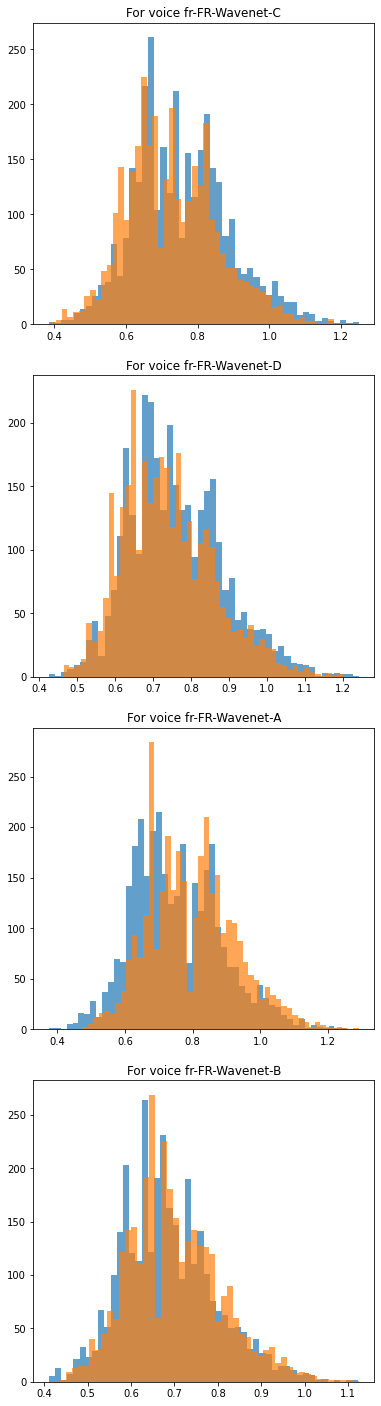

In [21]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes


fig, axs = plt.subplots(len(all_voices), 1)
fig.set_figheight(20)
fig.tight_layout(pad=3.0)

for (voice_id, dur_dict), ax in zip(synthed_audio_durations_nocuts.items(), axs):
    ax: Axes
    ax.hist([durs.text for _, durs in dur_dict.items()], bins=50, alpha=0.7)
    ax.hist([durs.phonetic_true for _, durs in dur_dict.items()], bins=50, alpha=0.7)
    ax.set_title(f"For voice {voice_id}")

plt.savefig("plots/duration_distrib_no_cuts.png")

In [13]:
from paraphone.tasks.filters.base import CandidatesPairCSV
from pathlib import Path
from dataclasses import dataclass
from tqdm import tqdm
from audioread import audio_open
from audioread.gstdec import GstAudioFile
import librosa
import numpy as np
import warnings
warnings.filterwarnings("ignore")


def get_dur(audio_path: Path) -> float:
    array, rate = librosa.load(str(audio_path), sr=None)
    non_zeros = np.nonzero(array)[0]
    true_start, true_end = non_zeros[0], non_zeros[-1]
    return (true_end - true_start) / rate


all_voices = {p.name for p in PHONETIC_SYNTH_DIR.iterdir()}
synthed_audio_durations = {}
for voice_id in all_voices:
    durations_dict = {}
    for word, phonetic, fake_phonetic in tqdm(corpus_64_pairs, total=corpus_64_pairs.lines_count):
        phonetic = phonetic.replace(" ", "_")
        fake_phonetic = fake_phonetic.replace(" ", "_")
        durations_dict[word]= Durations(
            text=get_dur(TEXT_SYNTH_DIR / Path(voice_id) / Path(f"{word}.ogg")),
            phonetic_true=get_dur(PHONETIC_SYNTH_DIR / Path(voice_id) / Path(f"{phonetic}.ogg")),
            phonetic_fake=0.0
        )
    synthed_audio_durations[voice_id] = durations_dict

100%|█████████▉| 3244/3245 [14:29<00:00,  3.73it/s]


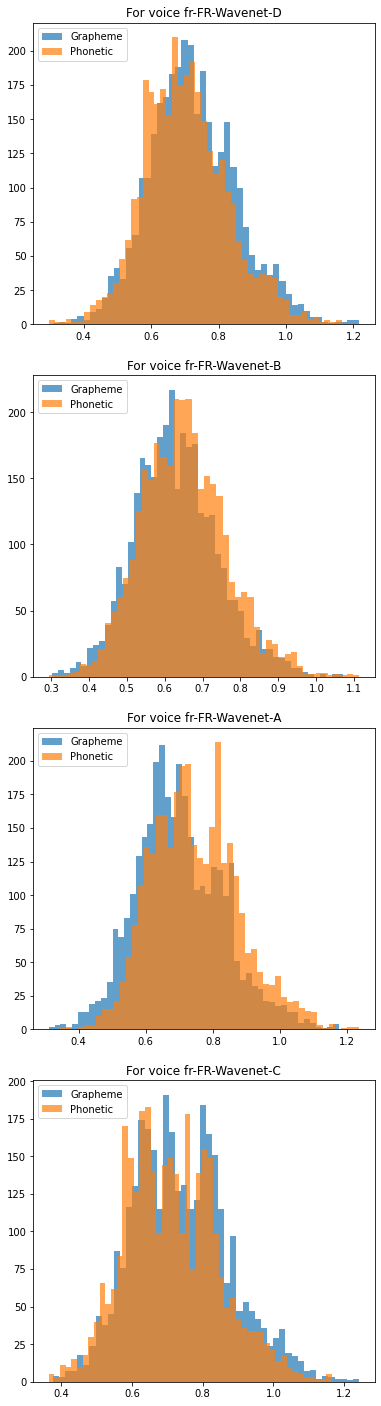

In [19]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sortedcontainers import SortedDict

fig, axs = plt.subplots(len(all_voices), 1)
fig.set_figheight(20)
fig.tight_layout(pad=3.0)

synthed_audio_durations = SortedDict(synthed_audio_durations)
for (voice_id, dur_dict), ax in zip(synthed_audio_durations.items(), axs):
    ax: Axes
    ax.hist([durs.text for _, durs in dur_dict.items()], bins=50, alpha=0.7, label="Grapheme")
    ax.hist([durs.phonetic_true for _, durs in dur_dict.items()], bins=50, alpha=0.7, label="Phonetic")
    ax.set_title(f"For voice {voice_id}")
    ax.legend(loc='upper left')

plt.savefig("plots/duration_distrib_cut.png")

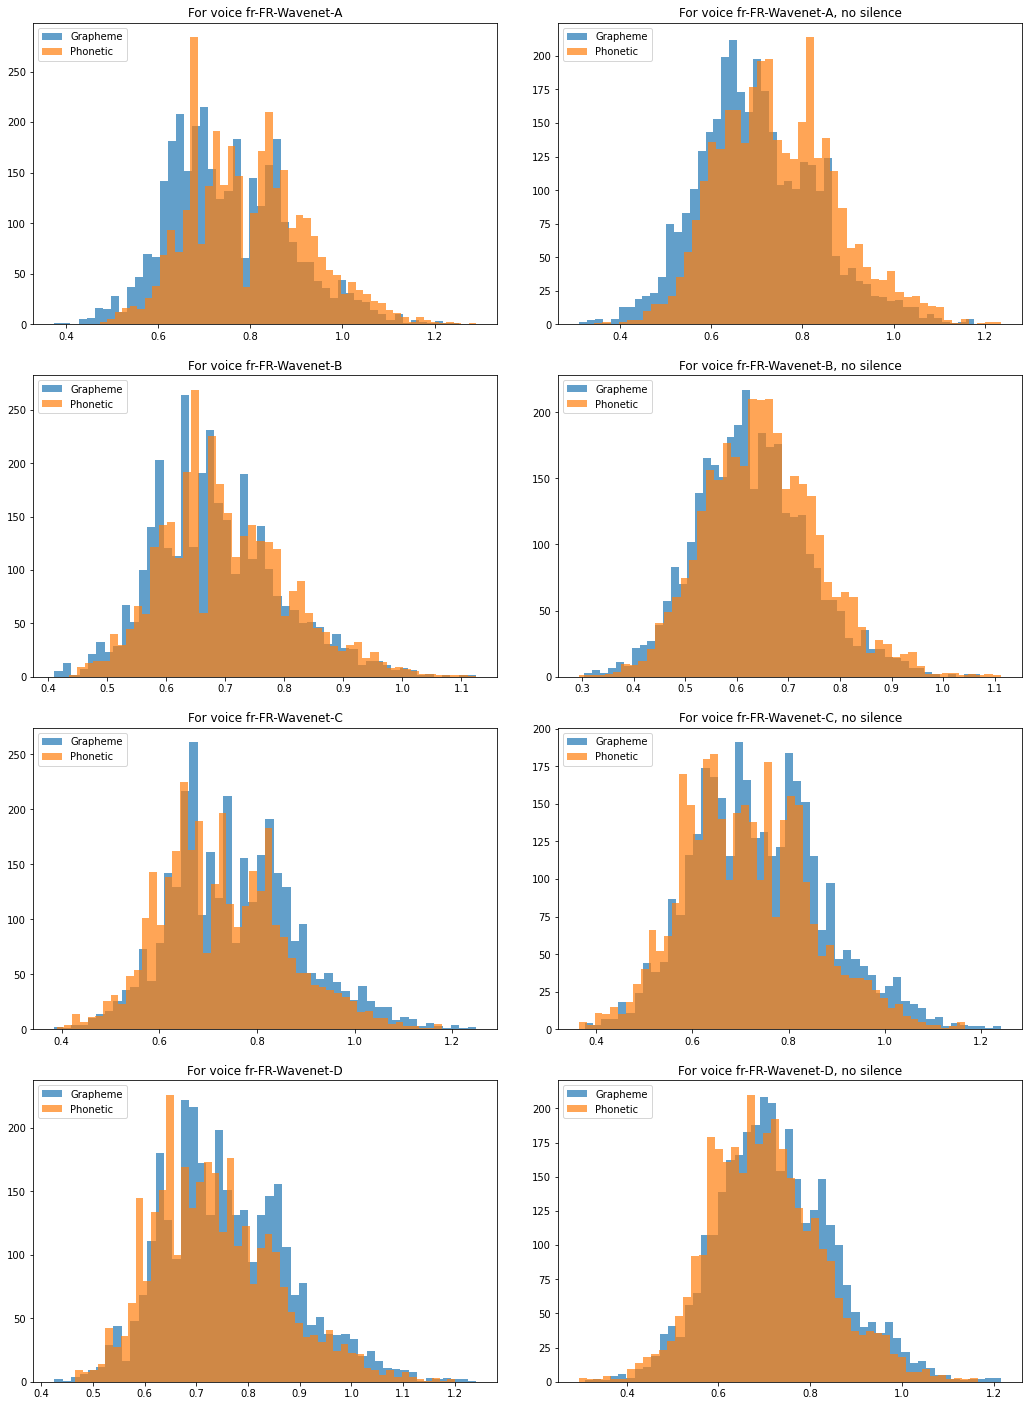

In [26]:
from typing import Dict

fig, axs = plt.subplots(len(all_voices), 2)
fig.set_figheight(20)
fig.set_figwidth(15)
fig.tight_layout(pad=3.0)

def show_hist(ax: Axes, dur_dict: Dict):
    ax.hist([durs.text for _, durs in dur_dict.items()], bins=50, alpha=0.7, label="Grapheme")
    ax.hist([durs.phonetic_true for _, durs in dur_dict.items()], bins=50, alpha=0.7, label="Phonetic")
    ax.legend(loc='upper left')

all_voices_sorted = sorted(list(all_voices))
for voice_id, (ax_nocut, ax_cut) in zip(all_voices_sorted, axs):
    no_cuts_dur_dict = synthed_audio_durations_nocuts[voice_id]
    cuts_dur_dict = synthed_audio_durations[voice_id]
    show_hist(ax_nocut, no_cuts_dur_dict)
    ax_nocut.set_title(f"For voice {voice_id}")
    show_hist(ax_cut, cuts_dur_dict)
    ax_cut.set_title(f"For voice {voice_id}, no silence")

plt.savefig("data/synth_duration_hist_both.png")

Text(0.5, 1.0, 'All voices, without silence')

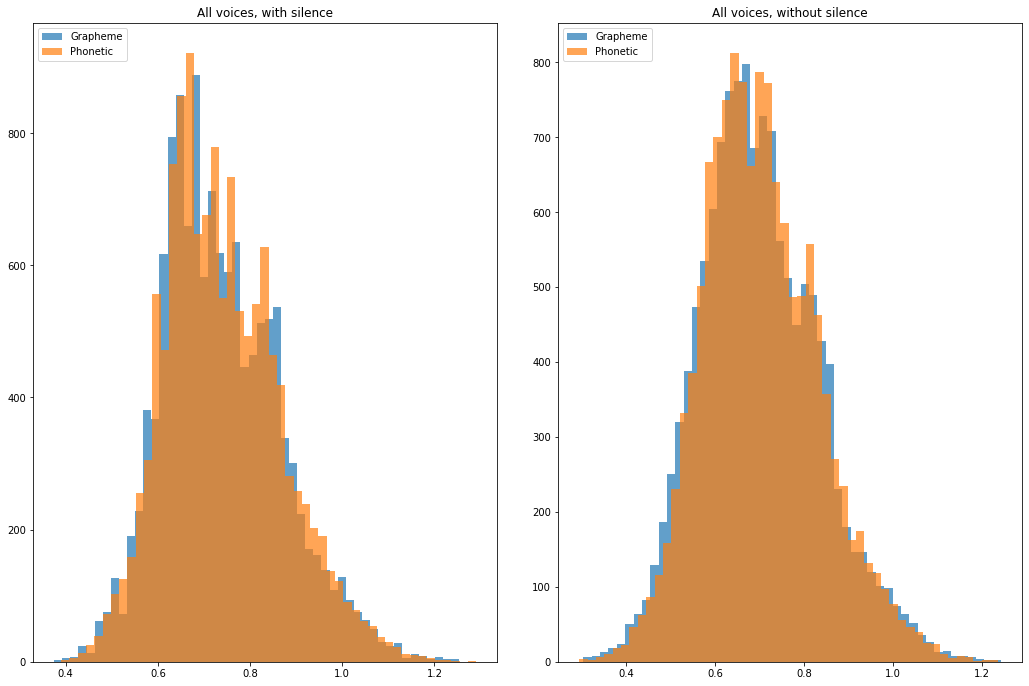

In [28]:
from itertools import chain
from typing import List

def show_hist(ax: Axes, dur_list: List[Durations]):
    ax.hist([durs.text for durs in dur_list], bins=50, alpha=0.7, label="Grapheme")
    ax.hist([durs.phonetic_true for durs in dur_list], bins=50, alpha=0.7, label="Phonetic")
    ax.legend(loc='upper left')

fig, (ax_nocuts, ax_cuts) = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.tight_layout(pad=3.0)
no_cuts_all_dur = list(chain.from_iterable(dur_dict.values() for dur_dict in synthed_audio_durations_nocuts.values()))
cuts_all_dur = list(chain.from_iterable(dur_dict.values() for dur_dict in synthed_audio_durations.values()))
show_hist(ax_nocuts, no_cuts_all_dur)
ax_nocuts.set_title("All voices, with silence")
show_hist(ax_cuts, cuts_all_dur)
ax_cuts.set_title("All voices, without silence")
